**This NB can be run on CPU too as we are not using LLM.**
> **We need GPU with around 12gb RAM to run this Notebook. You can use free GPU P100 available on kaggle or use Colab free GPU.**

# Different Retriever Evaluation Performance(as seen in last video)
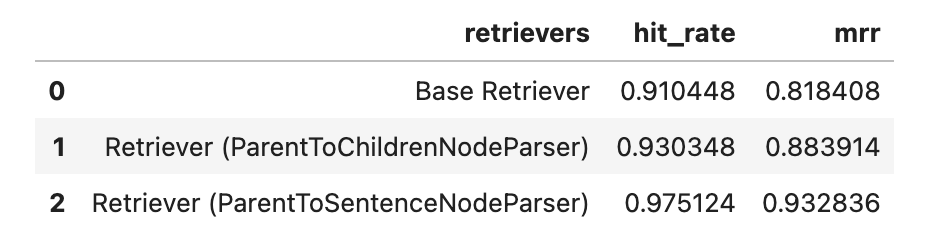


# Using Llama v.10

They have done lot of changes in their repo. You can refer to below blog post -

https://blog.llamaindex.ai/llamaindex-v0-10-838e735948f8

# Install Packages

In [1]:
!pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface transformers accelerate bitsandbytes --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.0 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 29.0.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you hav

# Downloading data
It's a pdf having current affairs info.

In [2]:
!mkdir -p 'data/'
!wget --user-agent "Mozilla" "https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf" -O "data/Yojana.pdf"

--2024-02-25 15:33:43--  https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf
Resolving chahalacademy.com (chahalacademy.com)... 103.227.176.27
Connecting to chahalacademy.com (chahalacademy.com)|103.227.176.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32739743 (31M) [application/pdf]
Saving to: 'data/Yojana.pdf'

data/Yojana.pdf     100%[===================>]  31.22M  10.8MB/s    in 2.9s    

2024-02-25 15:33:46 (10.8 MB/s) - 'data/Yojana.pdf' saved [32739743/32739743]



# Import required packages

In [3]:
from pathlib import Path
from llama_index.readers.file import PDFReader,PyMuPDFReader
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import VectorStoreIndex
from llama_index.core import Document
import json

import torch
from transformers import BitsAndBytesConfig
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode

# Loading the data

In [4]:
loader = PyMuPDFReader()
docs0 = loader.load_data(file_path=Path("./data/Yojana.pdf"))

doc_text = "\n\n".join([d.get_content() for idx, d in enumerate(docs0) if idx>2])
docs = [Document(text=doc_text)]

# Downloading bge-base embedding model

In [5]:
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# SentenceSplitter
Parse text with a preference for complete sentences.In general, this class tries to keep sentences and paragraphs together.

In [6]:
node_parser = SentenceSplitter(chunk_size=1024,chunk_overlap=0)
base_nodes = node_parser.get_nodes_from_documents(docs)
# set node ids to be a constant
for idx, node in enumerate(base_nodes):
    node.id_ = f"node-{idx}"

# Custom ParentToChildrenNodeParser
 > ### Smaller Child Chunks Referring to Bigger Parent Chunk

In this usage example, we show how to build a graph of smaller chunks pointing to bigger parent chunks.

During query-time, we retrieve smaller chunks, but we follow references to bigger chunks. This allows us to have more context for synthesis.

In [7]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode
from llama_index.core.utils import get_tqdm_iterable

class ParentToChildrenNodeParser(NodeParser):
    """Parent to Child node parser.

    Splits a document into a recursive hierarchy Nodes using a NodeParser.

    NOTE: this will return a hierarchy of nodes in a flat list, where there will be
    overlap between parent nodes (e.g. with a bigger chunk size), and child nodes
    per parent (e.g. with a smaller chunk size).

    For chunk_sizes as [2048, 512, 128]
        - First index value(2048) will be treated as parent node
        - Rest other index values(512,128) will be child nodes pointing directly to parent node(2048)
        using IndexNode.
    """

    chunk_sizes: Optional[List[int]] = Field(
        default=None,
        description=(
            "The chunk sizes to use when splitting documents, in order of level."
        ),
    )
    node_parser_ids: List[str] = Field(
        default_factory=list,
        description=(
            "List of ids for the node parsers to use when splitting documents, "
            + "in order of level (first id used for first level, etc.)."
        ),
    )
    node_parser_map: Dict[str, NodeParser] = Field(
        description="Map of node parser id to node parser.",
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_sizes: Optional[List[int]] = None,
        chunk_overlap: int = 20,
        node_parser_ids: Optional[List[str]] = None,
        node_parser_map: Optional[Dict[str, NodeParser]] = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        if node_parser_ids is None:
            if chunk_sizes is None:
                chunk_sizes = [2048, 512, 128]

            node_parser_ids = [f"chunk_size_{chunk_size}" for chunk_size in chunk_sizes]
            node_parser_map = {}
            for chunk_size, node_parser_id in zip(chunk_sizes, node_parser_ids):
                node_parser_map[node_parser_id] = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                )
        else:
            if chunk_sizes is not None:
                raise ValueError("Cannot specify both node_parser_ids and chunk_sizes.")
            if node_parser_map is None:
                raise ValueError(
                    "Must specify node_parser_map if using node_parser_ids."
                )

        return cls(
            chunk_sizes=chunk_sizes,
            node_parser_ids=node_parser_ids,
            node_parser_map=node_parser_map,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser_map[
                self.node_parser_ids[0]
            ].get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        all_nodes = []
        for node in nodes_with_progress:
            for level in range(len(self.node_parser_ids)):
                if level>0:
                    cur_sub_nodes = self.node_parser_map[
                        self.node_parser_ids[level]
                    ].get_nodes_from_documents([node])
                    sub_inodes = [
                        IndexNode.from_text_node(sn, node.node_id) for sn in cur_sub_nodes
                    ]
                    all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

# ParentToSentenceNodeParser

In [8]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode, TextNode
from llama_index.core.utils import get_tqdm_iterable
from llama_index.core.node_parser.text.utils import split_by_sentence_tokenizer

class ParentToSentenceNodeParser(NodeParser):
    """Parent to Sentence node parser.

    Splits a document into a Parent nodes and sentence nodes referring to parent node
    using a NodeParser.
    """

    chunk_size: int = Field(
        default=None,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )
    
    node_parser: SentenceSplitter = Field(
        default=SentenceSplitter,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_size: int = 1024,
        chunk_overlap: int = 20,
        node_parser: SentenceSplitter = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        
        node_parser = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                    )

        return cls(
            chunk_size=chunk_size,
            node_parser=node_parser,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser.get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        sent_node_parser = split_by_sentence_tokenizer()
        all_nodes = []
        for node in nodes_with_progress:
            sub_nodes = sent_node_parser(node.text)
            sub_inodes = [
                IndexNode.from_text_node(TextNode(text=sn), node.node_id) for sn in sub_nodes
            ]
            all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

# EnsembleRecursiveRetriever

In [9]:
from typing import Dict, List, Optional, Tuple, Union

from llama_index.core.base.base_query_engine import BaseQueryEngine
from llama_index.core.base.base_retriever import BaseRetriever
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.schema import (
    BaseNode,
    IndexNode,
    NodeWithScore,
    QueryBundle,
    TextNode,
)
from llama_index.core.utils import print_text

DEFAULT_QUERY_RESPONSE_TMPL = "Query: {query_str}\nResponse: {response}"


RQN_TYPE = Union[BaseRetriever, BaseQueryEngine, BaseNode]


class EnsembleRecursiveRetriever(BaseRetriever):
    """Recursive retriever.

    This retriever will recursively explore links from nodes to other
    retrievers/query engines.

    For any retrieved nodes, if any of the nodes are IndexNodes,
    then it will explore the linked retriever/query engine, and query that.

    Args:
        root_id (str): The root id of the query graph.
        retriever_dict (Optional[Dict[str, BaseRetriever]]): A dictionary
            of id to retrievers.
        query_engine_dict (Optional[Dict[str, BaseQueryEngine]]): A dictionary of
            id to query engines.

    """

    def __init__(
        self,
        root_ids: List[str],
        retriever_dict: Dict[str, BaseRetriever],
        top_k: int = 3,
        query_engine_dict: Optional[Dict[str, BaseQueryEngine]] = None,
        node_dict: Optional[Dict[str, BaseNode]] = None,
        callback_manager: Optional[CallbackManager] = None,
        query_response_tmpl: Optional[str] = None,
        verbose: bool = False,
    ) -> None:
        """Init params."""
        self._root_ids = root_ids
        for root_id in root_ids:
            if root_id not in retriever_dict:
                raise ValueError(
                    f"Root id {root_id} not in retriever_dict, it must be a retriever."
                )
        self._retriever_dict = retriever_dict
        self._top_k = top_k
        self._query_engine_dict = query_engine_dict or {}
        self._node_dict = node_dict or {}

        # make sure keys don't overlap
        if set(self._retriever_dict.keys()) & set(self._query_engine_dict.keys()):
            raise ValueError("Retriever and query engine ids must not overlap.")

        self._query_response_tmpl = query_response_tmpl or DEFAULT_QUERY_RESPONSE_TMPL
        super().__init__(callback_manager, verbose=verbose)

    def _deduplicate_nodes(
        self, nodes_with_score: List[NodeWithScore]
    ) -> List[NodeWithScore]:
        """Deduplicate nodes according to node id.
        Keep the node with the highest score/first returned.
        """
        node_ids = set()
        deduplicate_nodes = []
        for node_with_score in nodes_with_score:
            node = node_with_score.node
            if node.id_ not in node_ids:
                node_ids.add(node.id_)
                deduplicate_nodes.append(node_with_score)
        return deduplicate_nodes

    def _query_retrieved_nodes(
        self, query_bundle: QueryBundle, nodes_with_score: List[NodeWithScore]
    ) -> Tuple[List[NodeWithScore], List[NodeWithScore]]:
        """Query for retrieved nodes.

        If node is an IndexNode, then recursively query the retriever/query engine.
        If node is a TextNode, then simply return the node.

        """
        nodes_to_add = []
        additional_nodes = []
        visited_ids = set()

        # dedup index nodes that reference same index id
        new_nodes_with_score = []
        for node_with_score in nodes_with_score:
            node = node_with_score.node
            if isinstance(node, IndexNode):
                if node.index_id not in visited_ids:
                    visited_ids.add(node.index_id)
                    new_nodes_with_score.append(node_with_score)
            else:
                new_nodes_with_score.append(node_with_score)

        nodes_with_score = new_nodes_with_score

        # recursively retrieve
        for node_with_score in nodes_with_score:
            node = node_with_score.node
            if isinstance(node, IndexNode):
                if self._verbose:
                    print_text(
                        "Retrieved node with id, entering: " f"{node.index_id}\n",
                        color="pink",
                    )
                cur_retrieved_nodes, cur_additional_nodes = self._retrieve_rec(
                    query_bundle,
                    query_id=node.index_id,
                    cur_similarity=node_with_score.score,
                )
            else:
                assert isinstance(node, TextNode)
                if self._verbose:
                    print_text(
                        "Retrieving text node: " f"{node.get_content()}\n",
                        color="pink",
                    )
                cur_retrieved_nodes = [node_with_score]
                cur_additional_nodes = []
            nodes_to_add.extend(cur_retrieved_nodes)
            additional_nodes.extend(cur_additional_nodes)

        # dedup nodes in case some nodes could be retrieved from multiple sources
        nodes_to_add = self._deduplicate_nodes(nodes_to_add)
        additional_nodes = self._deduplicate_nodes(additional_nodes)
        return nodes_to_add, additional_nodes

    def _get_object(self, query_id: str) -> RQN_TYPE:
        """Fetch retriever or query engine."""
        node = self._node_dict.get(query_id, None)
        if node is not None:
            return node
        retriever = self._retriever_dict.get(query_id, None)
        if retriever is not None:
            return retriever
        query_engine = self._query_engine_dict.get(query_id, None)
        if query_engine is not None:
            return query_engine
        raise ValueError(
            f"Query id {query_id} not found in either `retriever_dict` "
            "or `query_engine_dict`."
        )

    def _retrieve_rec(
        self,
        query_bundle: QueryBundle,
        query_id: Optional[str] = None,
        cur_similarity: Optional[float] = None,
    ) -> Tuple[List[NodeWithScore], List[NodeWithScore]]:
        """Query recursively."""
        if self._verbose:
            print_text(
                f"Retrieving with query id {query_id}: {query_bundle.query_str}\n",
                color="blue",
            )
        query_id = query_id
        cur_similarity = cur_similarity or 1.0

        obj = self._get_object(query_id)
        if isinstance(obj, BaseNode):
            nodes_to_add = [NodeWithScore(node=obj, score=cur_similarity)]
            additional_nodes: List[NodeWithScore] = []
        elif isinstance(obj, BaseRetriever):
            with self.callback_manager.event(
                CBEventType.RETRIEVE,
                payload={EventPayload.QUERY_STR: query_bundle.query_str},
            ) as event:
                nodes = obj.retrieve(query_bundle)
                event.on_end(payload={EventPayload.NODES: nodes})

            nodes_to_add, additional_nodes = self._query_retrieved_nodes(
                query_bundle, nodes
            )

        elif isinstance(obj, BaseQueryEngine):
            sub_resp = obj.query(query_bundle)
            if self._verbose:
                print_text(
                    f"Got response: {sub_resp!s}\n",
                    color="green",
                )
            # format with both the query and the response
            node_text = self._query_response_tmpl.format(
                query_str=query_bundle.query_str, response=str(sub_resp)
            )
            node = TextNode(text=node_text)
            nodes_to_add = [NodeWithScore(node=node, score=cur_similarity)]
            additional_nodes = sub_resp.source_nodes
        else:
            raise ValueError("Must be a retriever or query engine.")

        return nodes_to_add, additional_nodes

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        retrieved_nodes = []
        for root_id in self._root_ids:
            nodes, _ = self._retrieve_rec(query_bundle, query_id=root_id)
            retrieved_nodes.extend(nodes)
        retrieved_nodes.sort(key=lambda x: x.get_score(), reverse=True)
        retrieved_nodes = self._deduplicate_nodes(retrieved_nodes)
        return retrieved_nodes[:self._top_k]

    def retrieve_all(
        self, query_bundle: QueryBundle
    ) -> Tuple[List[NodeWithScore], List[NodeWithScore]]:
        """Retrieve all nodes.

        Unlike default `retrieve` method, this also fetches additional sources.

        """
        return self._retrieve_rec(query_bundle, query_id=None)

# Evaluation
We evaluate how well our recursive retrieval + node reference methods work. We evaluate both chunk references as well as metadata references. We use embedding similarity lookup to retrieve the reference nodes.

We compare both methods against a baseline retriever where we fetch the raw nodes directly.

In terms of metrics, we evaluate using both hit-rate and MRR.

In [10]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)

import nest_asyncio

nest_asyncio.apply()

# Loading already generated testing data

In [11]:
try:
    eval_dataset = EmbeddingQAFinetuneDataset.from_json(
        "data/yojana_eval_dataset_qc.json"
    )
except:
    try:
      #path for kaggle
      eval_dataset = EmbeddingQAFinetuneDataset.from_json(
          "../input/rag-data/yojana_eval_dataset_qc.json"
      )
    except:
      # path for colab
      eval_dataset = EmbeddingQAFinetuneDataset.from_json(
          "./sample_data/yojana_eval_dataset_qc.json"
      )

In [12]:
len(list(eval_dataset.queries.keys())),len(base_nodes)

(201, 38)

# Remove invalid question

**It has only one word "What", that's why removed it.**

In [13]:
eval_dataset.queries.pop('28cd5213-a8a8-4ae3-8100-0caabdb114aa')

'What'

In [14]:
len(list(eval_dataset.queries.keys()))

200

# Compare Results

We run evaluations on each of the retrievers to measure hit rate and MRR.

**Hit rate** - The hit rate is a binary score indicating the presence of the correct chunk in the retrieved chunks. Score of 1 means are all correct chunk is present in retrieved chunks.

**Mean Reciprocal Ranking (MRR)** -  is a metric used to evaluate the effectiveness of search engines, recommendation systems, or any system that involves ranking a list of items. It's particularly common in information retrieval.

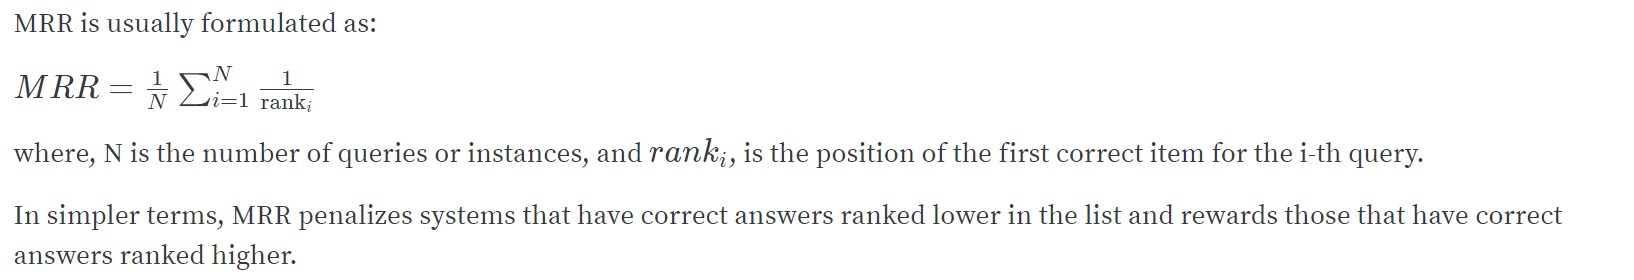

In [15]:
import pandas as pd
from llama_index.core.evaluation import (
    RetrieverEvaluator,
    get_retrieval_results_df,
)

# set vector retriever similarity top k to higher
top_k = 3


def display_results(names, results_arr):
    """Display results from evaluate."""

    hit_rates = []
    mrrs = []
    for name, eval_results in zip(names, results_arr):
        metric_dicts = []
        for eval_result in eval_results:
            metric_dict = eval_result.metric_vals_dict
            metric_dicts.append(metric_dict)
        results_df = pd.DataFrame(metric_dicts)

        hit_rate = results_df["hit_rate"].mean()
        mrr = results_df["mrr"].mean()
        hit_rates.append(hit_rate)
        mrrs.append(mrr)

    final_df = pd.DataFrame(
        {"retrievers": names, "hit_rate": hit_rates, "mrr": mrrs}
    )
    display(final_df)

# Base Retriever Evaluation

In [16]:
base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=top_k)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=base_retriever
)
# try it out on an entire dataset
results_base = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 200/200 [00:08<00:00, 24.99it/s]


# ParentToChildrenNodeParser

In [17]:
p2c_node_parser = ParentToChildrenNodeParser.from_defaults([1024,512,256], chunk_overlap=0)
all_nodes,all_base_nodes_dict = p2c_node_parser.get_nodes_from_documents(docs)
vector_index_chunk = VectorStoreIndex(all_nodes)
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=top_k)
retriever_chunk_p2c = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_base_nodes_dict,
    verbose=False,
)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_chunk_p2c
)
# try it out on an entire dataset
results_chunk_p2c = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 200/200 [00:10<00:00, 18.82it/s]


# ParentToSentenceNodeParser

In [18]:
p2s_node_parser = ParentToSentenceNodeParser.from_defaults(chunk_size=1024, chunk_overlap=0)
all_nodes_sent,all_base_nodes_dict_sent = p2s_node_parser.get_nodes_from_documents(docs)
vector_index_chunk_sent = VectorStoreIndex(all_nodes_sent)
vector_retriever_chunk_sent = vector_index_chunk_sent.as_retriever(similarity_top_k=top_k)
retriever_chunk_sent = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk_sent},
    node_dict=all_base_nodes_dict_sent,
    verbose=False,
)

retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_chunk_sent
)
# try it out on an entire dataset
results_chunk_sent = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


# EnsembleRecursiveRetriever

In [19]:
retriever_chunk_ens = EnsembleRecursiveRetriever(
    ["vector","vector1"],
    retriever_dict={"vector": vector_retriever_chunk,"vector1": vector_retriever_chunk_sent},
    top_k=top_k,
    node_dict=all_base_nodes_dict,
    verbose=False,
)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_chunk_ens
)
# try it out on an entire dataset
results_chunk_ens = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 200/200 [00:20<00:00,  9.62it/s]


# Hit Rate and MRR with top_k as 3

In [20]:
full_results_df = get_retrieval_results_df(
    [
        "Base Retriever",
        "Retriever (ParentToChildrenNodeParser)",
        "Retriever (ParentToSentenceNodeParser)",
        "Retriever (Ensemble Parser using P2C and P2S)",
    ],
    [results_base, results_chunk_p2c, results_chunk_sent, results_chunk_ens],
)
display(full_results_df)

,retrievers,hit_rate,mrr
0,Base Retriever,0.915,0.822500
1,Retriever (ParentToChildrenNodeParser),0.935,0.888333
2,Retriever (ParentToSentenceNodeParser),0.980,0.937500
3,Retriever (Ensemble Parser using P2C and P2S),1.000,0.964167
